# Big Data and Data Analytics - Lab Project 2
This lab project covers the material from Lectures 1-5. Please make yourself familiar with the lecture content before proceeding. We will be using the [**CSM**](https://archive.ics.uci.edu/ml/datasets/CSM+%28Conventional+and+Social+Media+Movies%29+Dataset+2014+and+2015) movie dataset courtesy of Mehreen Ahmed on the UCI Machine Learning Repository.

**<u>How to complete</u>**:
- For each exercise, read the objective and hint, and then fill the cells containing **TODO**. These will usually be code cells requiring you to write Python code. If we ask you to explain something in plaintext, these may also be Markdown cells.
- Do not modify any cells except for the ones containing **TODO**.
- Do not add or delete any cells from the notebook. If you add any cells during your work, please remove them before submitting.
- Allowed libraries are imported below. No additional libraries may be used for this lab project.
- **Run all cells before submitting. You will only get marks for code that has been run, and has not produced any errors.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison

If there are any errors during the import above, you may need to install the required libraries/packages libraries (e.g. "pip install ...").

## Exercise 1: Dataset Import, Exploration and Preparation (2 marks)¶

### Exercise 1.1 (1 mark)
- Load the dataset `moviedata.csv` into a pandas `DataFrame` named `df_movie`.
- Exclude all rows with missing data from `df_movie`.
- `print` the number of rows before and after removing observations with missing data in a single gramatically coherent sentence.

Hint: Look at the functions [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [`pd.isnull`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) and [`pd.DataFrame.any`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.any.html).

In [3]:
df_movie_raw = pd.read_csv("moviedata.csv")
df_movie = df_movie_raw.dropna()
df_movie_obs = len(df_movie.dropna())
df_movie_obs_null = len(df_movie_raw)
print("The number of rows before removing nulls was {} and the number of rows before rows with nulls removed is {}.".format(df_movie_obs_null,df_movie_obs))

The number of rows before removing nulls was 231 and the number of rows before rows with nulls removed is 187.


### Exercise 1.2 (1 mark)
- Create a new column `profit` in `df_movie` by subtracting the variables `gross` and `budget`.
- Create a new categorical column `sequelcat` in `df_movie` which takes the value `sequel` if the movie is a sequel, and `original` otherwise. 
- Find the five most profitable `original` movies and `print` their `movie` title and `profit` to the console (sorted as highest profit first).
- Find the five least profitable `sequel` movies and `print` these `movie` title and `profit` to the console (sorted as lowest profit first).

Hint: Look at [`pd.DataFrame.sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html), [`pd.DataFrame.astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html), [`pd.Series.cat.rename_categories`](https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.rename_categories.html) and the pandas slicing and subsetting notation.

In [4]:
df_movie = df_movie.assign(profit=df_movie["gross"]-df_movie["budget"])
sequelcat = pd.cut(df_movie['dummy_sequel'],bins=2,labels=['original','sequel'])
df_movie = df_movie.assign(sequelcat=sequelcat)

df_movie_original_profit = df_movie.sort_values(by=['sequelcat','profit'], ascending = [True,False]).iloc[0:5]
print(df_movie_original_profit[['movie','profit']])

df_movie_sequel_profit = df_movie.sort_values(by=['sequelcat','profit'], ascending = [False,True]).iloc[0:5]
print(df_movie_sequel_profit[['movie','profit']])

                       movie       profit
10           American Sniper  291200000.0
133           The Lego Movie  198000000.0
166               Inside Out  170000000.0
46   Guardians of the Galaxy  163000000.0
78                 Neighbors  132000000.0
                                       movie      profit
181                       Terminator Genisys -65600000.0
101             Sin City: A Dame to Kill For -51200000.0
118                        The Expendables 3 -50700000.0
79   Night at the Museum: Secret of the Tomb -13000000.0
59                 Jack Ryan: Shadow Recruit  -9500000.0


## Exercise 2: Visualisation (3 marks)

### Exercise 2.1 (1 mark)
Create a violin plot with an overlayed boxplot based on `df_movie` that shows the `profit` on the y-Axis separately for `original` movies and `sequel` movies. Color the violin plot blue for `original`s and orange for `sequel`s. Use an appropriate title and axis labels. 

Hint: Look at [`plt.violinplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.violinplot.html) and [`plt.boxplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html).

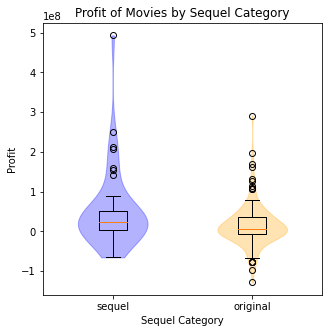

In [5]:
plotlabels = ['sequel', 'original'] 
plotdata = [df_movie[df_movie['sequelcat']==label]['profit'] for label in plotlabels] 
colors = ['blue','orange'] 
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot 
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) 
plt.boxplot(plotdata, widths=0.2, labels=plotlabels) # Overlay box plot
plt.xlabel('Sequel Category') # label data
plt.ylabel('Profit')
plt.title('Profit of Movies by Sequel Category') 
plt.show()

### Exercise 2.2 (1 mark)
- Create a new column `likes_winsor` in `df_movie` with a 5% winsorised version of the column `likes`. To make sure the winsorising worked, compare the minimum and maximum values of the two columns.
- Create a new column `ratingscat` based on `ratings` in `df_movie`, which describes the ratings category of a movie. Distinguish between the following categories:
    - `negative`: $0 <= ratings < 6$
    - `neutral`: $6 <= ratings < 6.8$
    - `positive`: $6.8 <= ratings <= 10$

Hint: For winsorising, you may use either the custom defined function from Lecture 3, or [`scipy.stats.mstats.winsorize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html). Also look at [`np.ndarray.min`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.min.html), [`np.ndarray.max`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.max.html), and [`pd.cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

In [14]:
def winsorize(x, limit): # Define winsorize function
    y = np.array(x, copy=True)
    b_low = np.sort(x)[int(limit*len(x))]
    b_high = np.sort(x)[int((1-limit)*len(x))-1]
    y[x < b_low] = b_low
    y[x > b_high] = b_high
    return y
data = df_movie['likes']
df_movie = df_movie.assign(likes_winsor=winsorize(data,0.05))
print("Checking min/max for likes vs winsorised likes:")
print(df_movie['likes'].min()) # checking min/max for likes vs winsorised likes
print(df_movie['likes'].max())
print(df_movie['likes_winsor'].min())
print(df_movie['likes_winsor'].max())
print("Original data: {}".format(data)) #original data
print("Trimmed data with custom function: {}".format(winsorize(data, 0.05))) #custom numpy function
print("Trimmed data with scipy function: {}".format(stats.mstats.winsorize(data, limits=[0.05, 0.05]))) #scipy method

# ratings categorisation into bins
df_movie = df_movie.assign(ratingscat = pd.cut(df_movie.ratings,bins=[0,6,6.8,10], right=False, labels=['negative','neutral','positive']))

Checking min/max for likes vs winsorised likes:
1
370552
85
36874
Original data: 0       4632
1       3465
2        328
3       2429
4      12163
       ...  
212    18398
213     3824
214    14359
215      115
216      109
Name: likes, Length: 187, dtype: int64
Trimmed data with custom function: [ 4632  3465   328  2429 12163  9595  2207  2210 11709 13143   963 36874
  5150    85  6983  2479  7633 14163  4404 18690  4572  6633  9202  2918
  6772  1348  3728  3400  1230  1248  7698  2571 29251 24226  8369  3946
  6490  1706  2968  1390  8567  1406 15479  5284 22779 36874    85 16635
  8886  4391  4322  4028  6917 36874 11187  7315    85  3528   595  4314
   469   890  6696  7342  8722 13535   895 36874   700 30208  3829   352
  2934  2124  1568 27484  9783 11733  6096 16782    85  3030 18770  3006
  9230  9463  2975  7682 27312 14539  4996 15351 17476  3964 15858 33092
 36874  4740  2187  3306 14152    85   277 14684 13331  4829  1606  1847
   238 18124    85  3089  1309 35071  3895  8

### Exercise 2.3 (1 mark)
Create a scatter plot for `gross` over `likes_winsor` in `df_movie`. This means that `likes_winsor` should occupy the x-Axis, and `gross` the y-Axis. Indicate the
different `ratingscat` categories by colouring movies with `negative` ratings in *Red*, `neutral` ratings in *Blue*, and `positive` ratings in *Green*. Please use an appropriate title and axis labels, as well as a legend.

Hint: Look at [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).

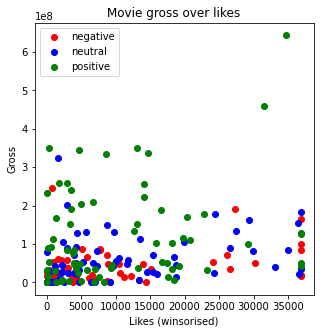

In [7]:
plotlabels = np.sort(df_movie['ratingscat'].unique())
plotdata = [df_movie[df_movie['ratingscat']==label][['likes_winsor', 'gross']] for label in plotlabels]
colors = 'red','blue','green' # Get colors
plt.figure(figsize=(5, 5)) # Specify figure size
for i, data in enumerate(plotdata):
    plt.scatter(data['likes_winsor'],data['gross'],color=colors[i],label="{}".format(plotlabels[i]))
plt.xlabel('Likes (winsorised)') # Set the label for the x axis
plt.ylabel('Gross') # Set the label for the y axis
plt.title('Movie gross over likes') # Set the figure title
plt.legend() # Add legend
plt.show()

## Exercise 3 (5 marks): Hypothesis testing

### Exercise 3.1 (1 mark)
- Create a new dataframe `df_movie_stats` which groups `df_movie` by `ratingscat` and `sequelcat` to describe each group by the number of observations and the means and standard deviations of `profit`, `gross`, and `budget`. `df_movie_stats` will hence contain six rows (3 possible values for `ratingscat` * 2 possible values for `sequelcat`) and have the columns `N`, `profit_mean`, `profit_std`, `gross_mean`, `gross_std`, `budget_mean`, and `budget_std`.
- `print` `df_movie_stats` to the console.

Hint: Look up [`pd.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [`pd.DataFrame.agg`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html).

In [8]:
df_movie_stats = df_movie.groupby(['ratingscat','sequelcat']).agg({'profit':['count', 'mean','std'],'gross':[ 'mean','std'],'budget':[ 'mean','std']})
print(df_movie_stats)

                     profit                                     gross  \
                      count          mean           std          mean   
ratingscat sequelcat                                                    
negative   original      41 -2.729568e+05  4.690779e+07  3.906034e+07   
           sequel        10  2.200300e+07  1.946555e+07  6.025300e+07   
neutral    original      50  8.570419e+06  4.052342e+07  4.618107e+07   
           sequel        18  3.473889e+07  7.219638e+07  9.811667e+07   
positive   original      54  3.355594e+07  6.182850e+07  8.350780e+07   
           sequel        14  9.831429e+07  1.409554e+08  2.665286e+08   

                                          budget                
                               std          mean           std  
ratingscat sequelcat                                            
negative   original   4.202196e+07  3.933329e+07  4.281692e+07  
           sequel     7.107304e+07  3.825000e+07  6.236508e+07  
neutral    origin

### Exercise 3.2 (1 mark)
- Based on `df_movie`, use a Bartlett’s test to test for variance homogeneity in the column `profit` across the three different ratings categories (column: `ratingscat`). `print` the resulting test statistic and p-value to the console.
- In your own words, explain what the null hypothesis is, and then interpret the results of the test.

Hint: Look at [`scipy.stats.bartlett`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html).

In [180]:
stat, p = stats.bartlett(df_movie[df_movie['ratingscat']=='negative']['profit'], df_movie[df_movie['ratingscat']=='neutral']['profit'], df_movie[df_movie['ratingscat']=='positive']['profit'])
print("test statistic chi_sq = {:.4f}; p-value = {:.4e}".format(stat, p))

test statistic chi_sq = 28.8257; p-value = 5.5028e-07


A null hypothesis in the context of Bartlett's test of Homogeneity suggests that here is no significant variance between the dependant variable/s and indepedendant variable for the selected subset of data. 

In our test we used a subset of movies.csv, selecting the dependant variable as profit across the independant categorical variable of 'ratingscat'. Having observed a very small (<0.5) p-value 5.5028e-07 we can reject the null hypothesis, concluding that the data is not homogenous and there is a significant difference between the variance of profit across the ratings categories of movies.  

### Exercise 3.3 (1 mark)
- Again based on `df_movie`, use a one‐way Analysis of Variance (ANOVA) to test whether there is a difference in mean `profit` across the three different ratings categories (column: `ratingscat`). `print` the resulting test statistic and p-value to the console.
- In your own words, explain what the null hypothesis is, and then interpret the results of the test.

Hint: Look at [`scipy.stats.f_oneway`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html).

In [181]:
stat, p = stats.f_oneway(df_movie[df_movie['ratingscat']=='negative']['profit'], df_movie[df_movie['ratingscat']=='neutral']['profit'], df_movie[df_movie['ratingscat']=='positive']['profit'])
print("test statistic F = {:.4f}; p-value = {:.4e}".format(stat, p))

test statistic F = 7.3630; p-value = 8.3911e-04


A null hypothesis in the context of an ANOVA test suggests that here is no significant difference in the mean for the dependant variable across the indepedendant variable for the selected subset of data.

In our test we used a subset of movies.csv, selecting the dependant variable as profit across the independant categorical variable of 'ratingscat', we observe a F statistic value of 7.3630 and a very small (<0.5) p-value 8.3911e-04 therefore, we can reject the null hypothesis, concluding that there is a significant variance of mean for profit across the ratings categories of movies.


### Exercise 3.4 (1 mark)
Continue working on the differences in mean `profit` between the `ratingscat` categories in `df_movie`.
- Conduct a PostHoc analysis with Tukey HSD to determine which pairs of categories (if any) have significantly different means from each other. `print` the results to the console.
- In your own words, interpret the results of the test.

Hint: Look at [`statsmodels.stats.multicomp.MultiComparison`](https://www.statsmodels.org/dev/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html). `MultiComparison` has been imported above.

In [182]:
comp = MultiComparison(df_movie['profit'], df_movie['ratingscat']).tukeyhsd().summary()
print(comp)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
 group1   group2     meandiff   p-adj      lower          upper     reject
--------------------------------------------------------------------------
negative  neutral   9497026.771 0.6781 -18025860.9828 37019914.5249  False
negative positive 44178628.6077 0.0013  14953701.7734 73403555.4419   True
 neutral positive 34681601.8366 0.0072   7866745.0997 61496458.5736   True
--------------------------------------------------------------------------


By observing the values for meandiff, we can see a significant difference in means between the pairs of categories 'negative','positive' and 'neutral','negative'. This is echoed in the last column 'reject' where the suggestion to reject the null hypothesis is being made for the two paired categories that exhibit the significant relationship, validated by an adjusted p-value of 0.0013 and 0.0072 respectively. 

### Exercise 3.5 (1 mark)
- Based on `df_movie`, compare the mean `profit`s for `original` and `sequel` movies (column: `sequelcat`).
- Choose an appropriate test to determine whether there is a significant difference. Conduct the test and `print` the results to the console.
- Explain your test choice and the results in your own words.

Hint: An additional test may be required to determine which test to use for comparing the means.

In [183]:
df_movie_stats = df_movie.groupby(['sequelcat']).agg({'profit':['mean']}) # comparing the mean 
print(df_movie_stats) 

seq_dist = stats.shapiro(df_movie['sequelcat']=='sequel') # checking for normal distribution 
orig_dist = stats.shapiro(df_movie['sequelcat']=='original')
print(seq_dist)
print(orig_dist)

stat, p = stats.f_oneway(df_movie[df_movie['sequelcat']=='original']['profit'], df_movie[df_movie['sequelcat']=='sequel']['profit'], df_movie[df_movie['ratingscat']=='positive']['profit'])
print("test statistic F = {:.4f}; p-value = {:.4e}".format(stat, p))

                 profit
                   mean
sequelcat              
original   1.537483e+07
sequel     5.289833e+07
ShapiroResult(statistic=0.515174150466919, pvalue=1.7809221559896246e-22)
ShapiroResult(statistic=0.5151721239089966, pvalue=1.7807560534374213e-22)
test statistic F = 7.5150; p-value = 6.8174e-04


To determine a significant difference in mean for profit across movie sequel categories, we firstly observe the difference in mean profit between the two groups original and sequel. Without yet performing any tests, there seems to be a difference observed in the values of the category means. To determine an optimal statistical test choice, we must first understand the distribution of the data. Using stats.shapiro to determine distribution, with a low p-value we can reject the null hypothesis that the categories individually do not conform to a normal distribution. With this information, we proceed to test whether there is a significant relationship across the means using the parametric statistical approach ANOVA which assumes a normal distribution. Our test produces an F-statistic of 7.5150 and p-value 6.8174e-04 suggesting that we can reject the null hypothesis and conclude that there is a significant relationship between the dependant variable profit and independant variable sequelcat. 